In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from math import *
from datetime import datetime
from datetime import timedelta
import statsmodels.tsa.stattools as stat

%matplotlib inline

In [2]:
with open ('sp_500_daily_return.csv') as return_data:
    global_sp_ret = pd.read_csv(return_data,engine='c')
    date_in_data=list(global_sp_ret.ix[:,0])

/home/xinlu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def date_int_to_string(date_int):
    year = int(date_int / 10000)
    month = int((date_int - 10000 * year)/100)
    day = date_int - 10000*year - 100*month
    
    year_str = str(year)
    
    if month < 10:
        month_str = '0' + str(month)
    else:
        month_str = str(month)
    
    if day < 10:
        day_str = '0' + str(day)
    else:
        day_str = str(day)
    
    return year_str + '-' + month_str + '-' + day_str

In [4]:
def data_process(start,period):
    with open ('sp_500_daily_prices.csv') as data:
        sp500=pd.read_csv(data,usecols=['date','COMNAM','PRC','RET','ASK','BID'],engine='c')
    date=sorted(list(set(sp500['date'])))
    try:
        date.index(start)
    except:
        raise (("Oops! The start date is not contained in our datesets.  Try again..."))
    try:
        train_start=date[-9*period+date.index(start)]
        date[date.index(start)+period]
    except:
        raise ("Oops! The period is too long.  Try again...")
    sp_recent=sp500[sp500['date']>=train_start]
    sp_recent=sp_recent[sp_recent['date']<=date[date.index(start)+period]]
    
    with open ('sp_500_daily_return.csv') as return_data:
        sp_ret=pd.read_csv(return_data,index_col=0,engine='c')
    sp_ret=sp_ret.loc[date[-9*period+date.index(start)]:date[period+date.index(start)]]
    return sp_recent,sp_ret,date

In [5]:
def filter_pair(pvalue_key,num):
    try:
        pvalue_key[num-1]
    except:
        raise("Oops! Too large num")
    selected_pair=[]
    stock_list=[]
    i=0
    while i<num:
        for pair in pvalue_key:
            if pair[1][0] not in stock_list and pair[1][1] not in stock_list:
                selected_pair+=[pair[1]]
                stock_list+=[pair[1][0]]
                stock_list+=[pair[1][1]]
                i+=1
    
    return selected_pair

In [6]:
def find_pair(start,period,num):
    sp_recent,sp_ret,date=data_process(start,period)
    error_return=['E','D','C','B','A','']
    sp_ret=sp_ret.applymap(lambda x:np.float64(0.0) if x in error_return else np.float64(x))
    sp_pca=np.array(sp_ret)
    #print(sp_pca)
    cov_company=np.cov(sp_pca)
    cov_company[np.isnan(cov_company)] = 0.0
    eigen_val,eigen_vector=np.linalg.eig(cov_company)
    eigen_vector_max=list(zip(eigen_vector[np.argmax(eigen_val)],sp_ret.columns))
    eigen_vector_max.sort(key=lambda x:x[0],reverse=True)
    eigen_vector_max=list(zip(*eigen_vector_max))
    data=sp_ret[list(eigen_vector_max[1][0:20])]
    pvalue_key=find_cointegrated_pairs(data)
    selected_pair=filter_pair(pvalue_key,num)
    data_inuse=sp_recent[sp_recent['date']>=date[-period+date.index(start)]]
    data_inuse=data_inuse[data_inuse['date']<date[date.index(start)+period]]
    data_inuse.fillna(method='ffill')
    
    companies=set(data_inuse['COMNAM'])
    company_data={}
    for company in companies:
        company_data[company]=data_inuse[data_inuse['COMNAM']==company]
    #print('find_pair_done')
    return company_data,selected_pair

In [7]:
def find_cointegrated_pairs(data):
    n = len(data.columns)
    #score_matrix = np.zeros((n, n))
    pvalue_key=[]
    keys = list(data.columns)
    #pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = np.array(data[keys[i]])
            S2 = np.array(data[keys[j]])
            result = stat.coint(S1, S2)
            #score = result[0]
            pvalue = result[1]
            pvalue_key+=[[pvalue,(keys[i],keys[j])]]
            #pairs.append((keys[i], keys[j]))
    pvalue_key=sorted(pvalue_key,key=lambda x:x[0])
    #print('find_cointegrated_pairs_done')
    return pvalue_key

In [83]:
start=20131001
end=20150101
period=120
num_pair=10

In [84]:
data,pairs=find_pair(start,period,num_pair)

/home/xinlu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/xinlu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [85]:
signal_opens  = ['O', 'C']        # open, close
signal_moves  = ['B', 'S']        # buy, sell

In [86]:
def generate_signal(priceA, priceB):
    '''Find the trading signal in one window, default as 60 days'''
    
#    assert len(Areturn)==len(Breturn),"Wrong data extraction!"
    assert len(priceA)==len(priceB),"Wrong data extraction!"
    Areturn = np.diff(priceA)/priceA[:(len(priceA)-1)]
    Breturn = np.diff(priceB)/priceB[:(len(priceB)-1)]
    
    # regression on return
    beta, beta0, r_value, p_value, std_err = stats.linregress(Areturn, Breturn)

    # get the residual epsilon_t
    e_t = np.array(Breturn - beta0 - beta*Areturn)

    Xt=[np.sum(e_t[:i+1]) for i in range(len(Areturn))]

    # regression on X_t
    length = len(Xt)
    Xt_vec = np.array(Xt)
    b, a, r_value_x, p_value_x, std_err_x = stats.linregress(Xt_vec[1:],Xt_vec[:length-1])

    # get the residual zeta_t
    z_t = Xt_vec[:length-1] - a - b*Xt_vec[1:]
    var_z = np.var(z_t)

    # calculate the s-score
    s_score = -a*sqrt(1-b**2)/((1-b)*sqrt(var_z)) + int(a/(1-b))*sqrt((1-b**2)/var_z)

    # trading signal
    if s_score   < -1.1:
        signal_open = signal_opens[0]
        signal_move = signal_moves[0]
    elif s_score > 1.1:
        signal_open = signal_opens[0]
        signal_move = signal_moves[1]
    ### what if s_score=0 so that it satisfy both condition?
    elif s_score < 0.65:
        signal_open = signal_opens[1]
        signal_move = signal_moves[0]
    elif s_score > -0.65:
        signal_open = signal_opens[1]
        signal_move = signal_moves[1]
        ### if a possible error, use try except
    else:
        raise('Warning!')

    return beta,signal_open, signal_move

In [87]:
position_dict = {}  # static variable: 'StockA': position
cash = 50000        # static variable


def build_position(position_dict, cash, pairs, data, window):
    '''build position for each window
    
    Default parameters
    ------------------
    shares per trade:1000
    transaction cost fee: 0.0005
    '''
    # borrow cost of stock = 0.05 of short position
    borrow_cost = 0.05
    transaction_cost = 0.003
    portfolio_value = []
    
    
    for i in range(window):
        cash_old = cash
        stock_value = 0
        for pair in pairs:
#            Areturn        = data[pair[0]]['RET'].values[i:i+60]
#            Breturn        = data[pair[1]]['RET'].values[i:i+60]
            priceA         = data[pair[0]]['PRC'].values[i:i+window]
            priceB         = data[pair[1]]['PRC'].values[i:i+window]
            tickerA        = pair[0]
            tickerB        = pair[1]
            BidA           = data[pair[0]]['BID'].values
            AskA           = data[pair[0]]['ASK'].values
            BidB           = data[pair[1]]['BID'].values
            AskB           = data[pair[1]]['ASK'].values
            result         = generate_signal(priceA, priceB)
            beta           = result[0]
            open_or_not    = result[1]
            buy_or_sell    = result[2]
            
            # for A
            if (tickerA in position_dict.keys()): 
                if open_or_not == 'C':
                    if buy_or_sell == 'B':
                        cash -= (AskA[i+window]+transaction_cost)*abs(position_dict[tickerA])
                        position_dict[tickerA] = 0
                    else:
                        cash += (BidA[i+window]-transaction_cost)*abs(position_dict[tickerA])
                        position_dict[tickerA] = 0
                else:
                    if buy_or_sell == 'B':
                        position_dict[tickerA] -= int((cash/len(pairs))/AskB[i+window]*beta)
                        cash += (1-borrow_cost)*(cash/len(pairs))/AskB[i+window]*beta*(BidA[i+window]-transaction_cost)
                    else:
                        position_dict[tickerA] += int((cash/len(pairs))/BidB[i+window]*beta)
                        cash -= (cash/len(pairs))/BidB[i+window]*beta*(AskA[i+window]+transaction_cost)
            else:
                if open_or_not == 'C':
                    position_dict[tickerA] = 0
                    cash += 0
                else:
                    if buy_or_sell == 'B':
                        position_dict[tickerA] = -int((cash/len(pairs))/AskB[i+window]*beta)
                        cash += (1-borrow_cost)*abs(position_dict[tickerA])*(BidA[i+window]-transaction_cost)
                    else:
                        position_dict[tickerA] = int((cash/len(pairs))/BidB[i+window]*beta)
                        cash -= abs(position_dict[tickerA])*(AskA[i+window]+transaction_cost)
            
            # for B
            if (tickerB in position_dict.keys()):
                if open_or_not == 'C':
                    if buy_or_sell == 'B':
                        cash += (BidB[i+window]-transaction_cost)*abs(position_dict[tickerB])
                        position_dict[tickerB] = 0
                    else:
                        cash -= (AskB[i+window]+transaction_cost)*abs(position_dict[tickerB])
                        position_dict[tickerB] = 0
                else:
                    if buy_or_sell == 'B':
                        position_dict[tickerB] += int((cash/len(pairs))/AskB[i+window])
                        cash -= (cash/len(pairs))/AskB[i+window]*(AskB[i+window]+transaction_cost)
                    else:
                        position_dict[tickerB] -= int((cash/len(pairs))/BidB[i+window])
                        cash += (1-borrow_cost)*(cash/len(pairs))/BidB[i+window]*(BidB[i+window]-transaction_cost)
            else:
                if open_or_not == 'C':
                    position_dict[tickerB] = 0
                    cash += 0
                else:
                    if buy_or_sell == 'B':
                        position_dict[tickerB] = int((cash/len(pairs))/AskB[i+window])
                        cash -= abs(position_dict[tickerB])*(AskB[i+window]+transaction_cost)
                    else:
                        position_dict[tickerB] = int((cash/len(pairs))/BidB[i+window])
                        cash += (1-borrow_cost)*abs(position_dict[tickerB])*(BidB[i+window]-transaction_cost)
            
            stock_value += data[pair[0]]['PRC'].values[i+window]*position_dict[tickerA] \
                          +data[pair[1]]['PRC'].values[i+window]*position_dict[tickerB]
        portfolio_value.append(cash + stock_value)
            
        
    
    return position_dict, cash, portfolio_value

In [88]:
result = build_position(position_dict, cash, pairs, data, 120)

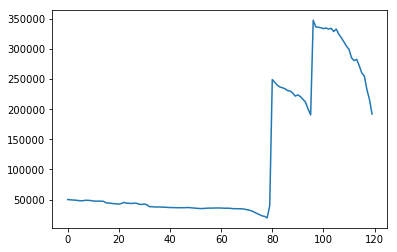

In [89]:

portfolio_value = result[2]
plt.plot(result[2])

In [17]:
def add_date(start_date, add_days):
    year = int(start_date/10000)
    month = int(start_date/100)- year*100
    day = start - year*10000 - month*100
    
    date1 = datetime(year, month, day)
    date2 = date1 + timedelta(days=add_days)
    
    new_date  = date2.year * 10000 + date2.month * 100 + date2.day
    return new_date
    

In [72]:
def backtest(start_date, end_date, pair_num):
    position_long = {}  # static variable: 'StockA': position
    position_short = {}
    
    with open ('SP500TR.csv') as return_data:
        sp500_index = pd.read_csv(return_data,engine='c')
        sp500_index = sp500_index[['Date','Adj Close']]

    with open ('TNX.csv') as return_data:
        rf_rate = pd.read_csv(return_data,engine='c')
    
    rf_rate = rf_rate[['Date','Adj Close']]
    win_len = 60
    start_date_index  = date_in_data.index(start_date)
    end_date_index = date_in_data.index(end_date)
    win_num = int((end_date_index - start_date_index + 1)/win_len)
    pair_start_date = date_in_data[start_date_index -win_len * 9]
    
    date_str = date_int_to_string(start_date)
    sp500_start_index = sp500_index[sp500_index['Date'] == date_str].index.tolist()[0]
    
    sp500_index = sp500_index['Adj Close'][sp500_start_index : sp500_start_index + end_date_index - start_date_index + 1]
    sp500_return = np.diff(sp500_index) / sp500_index[:(len(sp500_index)-1)]
    
    rf_rate_start_index = rf_rate[rf_rate['Date'] == date_str].index.tolist()[0]
    rf_rate_start = float(rf_rate['Adj Close'][rf_rate_start_index])
    
    cash = 50000
    
    #pair_end_date = add_date(start_date, win_len - 1)
    
    portfolio_value_list = []
    
    for i in range(win_num):
        print("start: ", pair_start_date)
        data, pairs = find_pair(pair_start_date, win_len, pair_num)
        position_long, position_short, cash, PNL, portfolio_value = build_position(position_long, position_short, cash, pairs, data, win_len, -1.25,-0.5,0.5,1.25)
        print(portfolio_value)
        print(position_long)
        print(position_short)
        portfolio_value_list = portfolio_value_list + list(portfolio_value)
        start_date_index += win_len
        pair_start_date = date_in_data[start_date_index - win_len * 9]
        print(cash)
    
    last_win_len = (end_date_index - start_date_index + 1) % win_len
    
    print("start: ", pair_start_date)
    data, pairs = find_pair(pair_start_date, last_win_len, pair_num)
    position_long, position_short, cash, PNL, portfolio_value = build_position(position_long, position_short, cash, pairs, data, last_win_len,  -1.25,-0.5,0.5,1.25)
    portfolio_value_list = portfolio_value_list + list(portfolio_value)
    print(cash)
    

    

    #rf_rate_start = 0.03
    
    
    return_list = np.diff(portfolio_value_list)/portfolio_value_list[:(len(portfolio_value_list)-1)]
    print("return list length ",len(return_list))
    
    sharp_ratio = (np.mean(return_list) - rf_rate_start) / sqrt(np.var(return_list))
                   
    max_here = pd.expanding_max(return_list)
    dd2here = return_list - max_here
    max_drawdown = dd2here.min()
    
    if return_list[0] == inf or return_list[0] == -inf:
        return_list[0] = 0
        
    for i in range(1, len(return_list)):
        if return_list[i] == inf or return_list[i] == -inf:
            return_list[i] = return_list[i-1]
    
    print(len(return_list))
    print(len(sp500_return))        
    beta = np.cov(return_list, sp500_return)[1,0] / np.var(sp500_return)
    
    return return_list, sp500_return, sharp_ratio, max_drawdown, beta
      

In [ ]:
start_date = date_in_data[4960]
end_date = date_in_data[5300]
result = backtest(start_date, end_date, 10)


start:  20070716


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


[49630.287000000004, 49392.059999999998, 49100.781999999992, 48829.990999999995, 48558.470000000001, 48270.328999999998, 65522.260999999999, 64780.368000000002, 129315.33200000002, 127474.38900000002, 127620.59600000002, 128084.00700000003, 126898.55100000004, 125300.76700000004, 125311.42400000003, 122245.64600000004, 121018.02300000004, 119742.46700000006, 119228.78100000006, 113651.36100000008, 117134.83400000006, 120166.85700000005, 119077.80500000005, 141484.52100000001, 141714.99300000005, 143485.68700000003, 144009.37000000005, 144178.02600000004, 145552.06400000004, 145794.84000000008, 146413.39300000004, 144903.10400000005, 141128.32900000006, 144569.7790000001, 145646.80900000007, 146517.81900000008, 148127.13100000008, 148679.36500000008, 148607.96500000008, 195812.78700000007, 193482.02300000007, 191005.20900000006, 189271.48100000003, 183752.35500000007, 181931.11900000006, 182963.92000000004, 192637.65500000003, 195956.24300000007, 194427.81600000011, 193370.18200000003, 

In [64]:
date_in_data[4960]

20090903

In [45]:
date_in_data[5500]

20111025

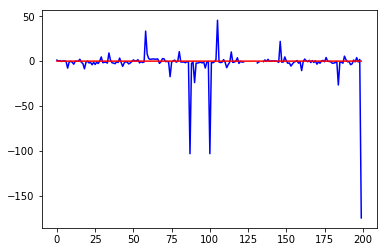

In [236]:
x = range(len(result[0]))
plt.plot(x,result[0],color = 'blue')
plt.plot(x,result[1], color =  'red')